In [15]:
import torch, os, json, math, torch.nn as nn, pytorch_lightning as pl, numpy as np, scipy.stats as stats, random
from torch.utils.data import DataLoader, Dataset
import logging
import tqdm
class PathwaysSampler():
    def __init__(self, allowed_cmms, classes_map = "path_to_cmm.json", path = "/workspace/smartmwms/data_siamese"):
        """Generates a pathways sampler

        Args:
            path (string): Path to folder containing metadata files. Classmap should be in {path}/npclassifier/pathways/{classes_map}
        """
        super().__init__()

        self.my_logger = logging.getLogger("lightning")

        self.my_logger.info(f"Enter Samplers")
        self.my_logger.info(f"PathwaysSampler: {classes_map}")

        allow = set(allowed_cmms)
        with open(os.path.join(path, "npclassifier", "pathways", classes_map), "r") as f:
            # dictionary mapping pathways to all cmms
            self.meta = json.load(f)
        
        # convert all values to a set, and intersect with only the allowed values
        for classs, vals in self.meta.items():
            vals = set(vals)
            self.meta[classs] = list(vals.intersection(allow))

        self.pathways_and_empty = list(set([k for k,v in self.meta.items() if len(v) >= 2]))
        self.pathways = list(set(self.pathways_and_empty) - set(["EMPTY"]))
        self.all_samples = []
        self.all_labels = []

        self.my_logger.info(f"PathwaysSampler classes_all: {str(self.pathways_and_empty)}")

        self.my_logger.info(f"Exit Samplers")
        for k, p in self.meta.items():
            self.all_samples += p
            self.all_labels += [k] * len(p)
    
    def get_classes(self):
        return self.pathways
    
    def ct_samples(self):
        return len(self.all_samples)
    
    def get_sample(self, i):
        return self.all_samples[i], self.all_labels[i]
        
    def sample_real_class(self):
        return random.choice(self.pathways)

    def sample_all_class(self):
        return random.choice(self.pathways_and_empty)

    def sample_from_class(self, classs):
        return random.choice(self.meta[classs])

    def sample_neg_real_class(self, classs):
        classs2 = self.sample_real_class()
        while classs2 == classs:
            classs2 = self.sample_real_class()
        return self.sample_from_class(classs2)

    def sample_neg_all_class(self, classs):
        classs2 = self.sample_all_class()
        while classs2 == classs:
            classs2 = self.sample_all_class()
        return self.sample_from_class(classs2)
    
class SiameseCustomizableTripletDataset(Dataset):
    def __init__(self, sampler, dimensions = 2995, size = 50000, path = "./data_siamese/singular_specs", small = False):
        self.path = path
        self.size = size if not small else 30
        self.dimensions = dimensions
        self.sampler = sampler
    def __len__(self):
        return self.size

    def load_spec(self, i):
        '''
        Reads the spec with the given CMM (CMMSLIB%%%%%%%%.npy) from the {path} folder. Do not include .npy
        in the filename. Loads the first {dimensions} dimensions of the float array. 
        '''
        return np.load(os.path.join(self.path, i + ".npy"))[:self.dimensions].astype("float32")

    def __getitem__(self, i):
        '''
        Samples an item. Samples a random class (main class) and samples an anchor from there. Then, 
        Samples another different molecule as the positive pair. Then samples another class and another sample
        for the negative pair. Returns the three spectra as a 3-tuple. 
        '''
        class1 = self.sampler.sample_real_class()
        cmm1 = self.sampler.sample_from_class(class1)
        cmm2 = self.sampler.sample_from_class(class1)
        while cmm1 == cmm2:
            cmm2 = self.sampler.sample_from_class(class1)
        cmm3 = self.sampler.sample_neg_real_class(class1)

        return self.load_spec(cmm1).reshape((1, -1)), self.load_spec(cmm2).reshape((1, -1)), self.load_spec(cmm3).reshape((1, -1))

In [14]:
with open("./pathways_metadata/npclassifier/pathways/train.json", "r") as f:
    objtr = json.load(f)
with open("./pathways_metadata/npclassifier/pathways/val.json", "r") as f:
    objva = json.load(f)

paths, scs = "path_to_cmm.json", "sc_to_cmm.json"
ps_tr = PathwaysSampler(objtr, paths, "./pathways_metadata")
ps_va = PathwaysSampler(objva, paths, "./pathways_metadata")
ds_va = SiameseCustomizableTripletDataset(ps_va, path = "../smart_data/singular_specs")

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
pos = []
neg = []
ct = 50000
for i in tqdm.tqdm(range(ct)):
    a, p, n = ds_va[i]
    sim_pos, sim_neg = cosine_similarity(a, p), cosine_similarity(a, n)
    pos.append(sim_pos)
    neg.append(sim_neg)
print(len(pos), len(neg))

100%|██████████| 50000/50000 [01:28<00:00, 567.52it/s]

50000 50000


In [39]:
perf = cosine_similarity(np.array([[1,1, 1]]), np.array([[1, 1, 1]]))
bad = cosine_similarity(np.array([[1,0, 0]]), np.array([[0, 0, 1]]))
print(f"perf: {perf}, bad: {bad}")
# cosinsim = 1 = perfect, 

perf: [[1.]], bad: [[0.]]


In [29]:
posf, negf = np.array(pos).flatten(), np.array(neg).flatten()
print(len(pos), len(neg))

50000 50000


In [40]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
labs = [0] * len(pos) + [1] * len(neg)
dist = np.concatenate((negf, posf), axis=0)
fpr, tpr, thresh = roc_curve(labs, dist, pos_label=1)

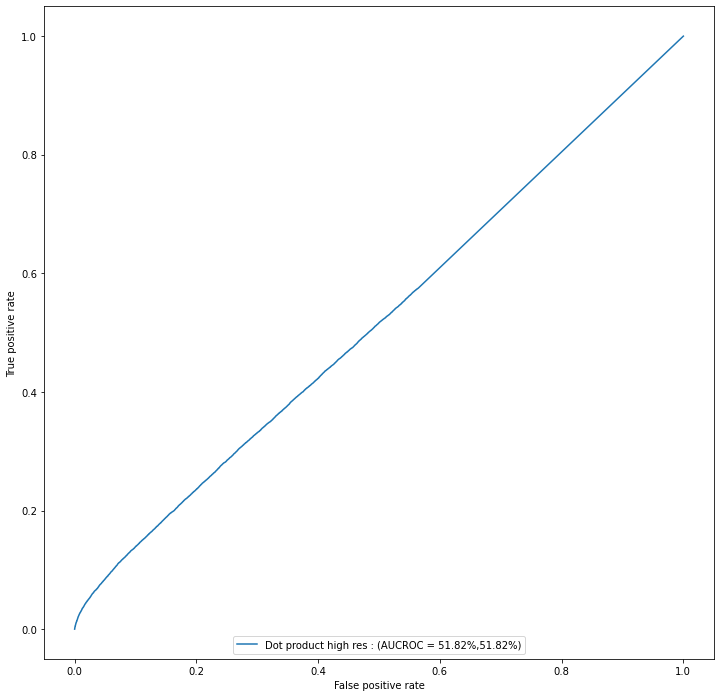

In [43]:
from matplotlib import pyplot as plt
width = 12
fig, ax = plt.subplots(figsize=(width, width), facecolor='w')
ax.plot(fpr, tpr,
        label=f'Dot product high res : (AUCROC = {auc(fpr, tpr):.2%},{roc_auc_score(labs, dist):.2%})')
ax.legend(loc='lower center')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
plt.show()